## Table Transformer: inference notebook

In this notebook, we are going to run the Table Transformer - which is actually a [DETR](https://arxiv.org/abs/2005.12872) model - by Microsoft Research (which is part of 🤗 Transformers) to perform table detection and table structure recognition on documents.

### Quick intro: DETR
DETR is short for DEtection TRansformer, and consists of a convolutional backbone (ResNet-50 or ResNet-101) followed by an encoder-decoder Transformer. It can be trained end-to-end to perform object detection (and panoptic segmentation, for that see my other notebooks in my repo [Transformers-tutorials](https://github.com/NielsRogge/Transformers-Tutorials)).The main contribution of DETR is its simplicity: compared to other models like Faster R-CNN and Mask R-CNN, which rely on several highly engineered things like region proposals, non-maximum suppression procedure and anchor generation, DETR is a model that can simply be trained end-to-end, and fine-tuned just like you would fine-tune BERT. This is possible due to the use of a clever loss function, the so-called **bipartite matching loss**. I highly recommend [Yannic Kilcher's video](https://www.youtube.com/watch?v=T35ba_VXkMY&t=1693s) if you want to understand how the full model works.

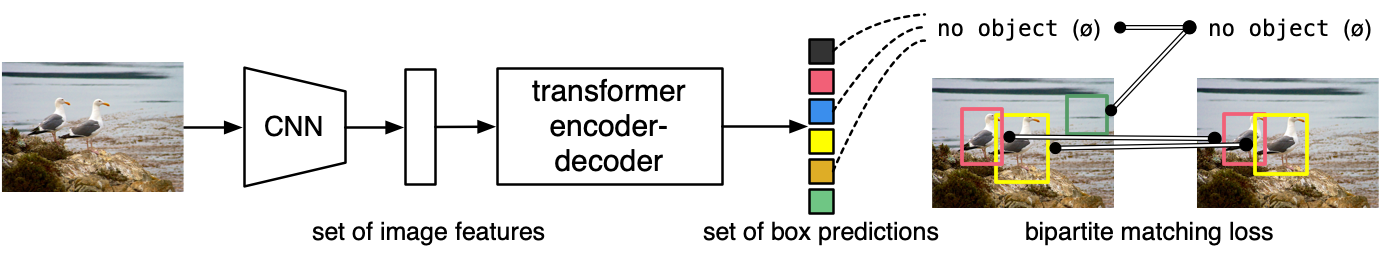

* Table Transformer paper: https://arxiv.org/abs/2110.00061
* DETR Paper: https://arxiv.org/abs/2005.12872
* DETR Blog post: https://ai.facebook.com/blog/end-to-end-object-detection-with-transformers/
* Official Github repository: https://github.com/facebookresearch/detr

My other DETR notebooks (which showcase how you can fine-tune DETR on a custom dataset, both for object detection and panoptic segmentation) can be found [here](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/DETR).


## 0. Path

In [ ]:
%pip install -q git+https://github.com/huggingface/transformers.git

In [ ]:
%pip install -q timm

In [ ]:
p = Path('./samples/')

In [ ]:
str(p)

In [ ]:
p.is_dir

In [ ]:
q = p / 'do-0002.pdf'



In [ ]:
q

In [ ]:
str(q)

In [ ]:
q.resolve()

In [ ]:
p = Path('./samples/')
[x for x in p.iterdir() if x.is_dir()]

In [ ]:
p = Path('.')
[x for x in p.iterdir() if x.is_dir()]

### testes pathlib

In [ ]:
import os
os.name

Path('./samples/do-0002.pdf')



In [ ]:
list(p.glob('**/*.pdf'))


In [ ]:
from pathlib import PurePath

In [ ]:
from pathlib import PureWindowsPath

In [ ]:
import os
p = PureWindowsPath('\samples')
os.fspath(p)

In [ ]:
str(p)

In [ ]:
p = PurePath('/etc')
str(p)

p = PureWindowsPath('c:/Program Files')
str(p)


## 1. Table detection

In [1]:
from pathlib import Path
from pathlib import WindowsPath

In [2]:
wp = WindowsPath('./PDF_samples/do-01764.pdf')
wp

WindowsPath('PDF_samples/do-01764.pdf')

In [4]:
wp = WindowsPath('./PDF_samples/do-01773.pdf')
wp

WindowsPath('PDF_samples/do-01773.pdf')

In [ ]:
wp = WindowsPath('./PDF_samples/do-01780.pdf')
wp

### testes image

In [5]:
# Yes!!!!!
from pdf2image import convert_from_path
pages = convert_from_path(wp, 500,poppler_path=r'C:\Users\danie\Downloads\Release-23.07.0-0\poppler-23.07.0\Library\bin')

image_counter = 1

for page in pages:
    filename = "PDF_samples/PDF_pages/page_" + str(image_counter) + ".jpg"
    page.save(filename, 'JPEG')
    image_counter = image_counter + 1

In [6]:
from PIL import Image

In [7]:
Image_file = "PDF_samples/PDF_pages/page_1.jpg"

In [20]:
Image_file = "PDF_samples/PDF_pages/page_2.jpg"

In [58]:
Image_file = "PDF_samples/PDF_pages/page_8.jpg"

In [45]:
Image_file = "PDF_samples/PDF_pages/page_4.jpg"

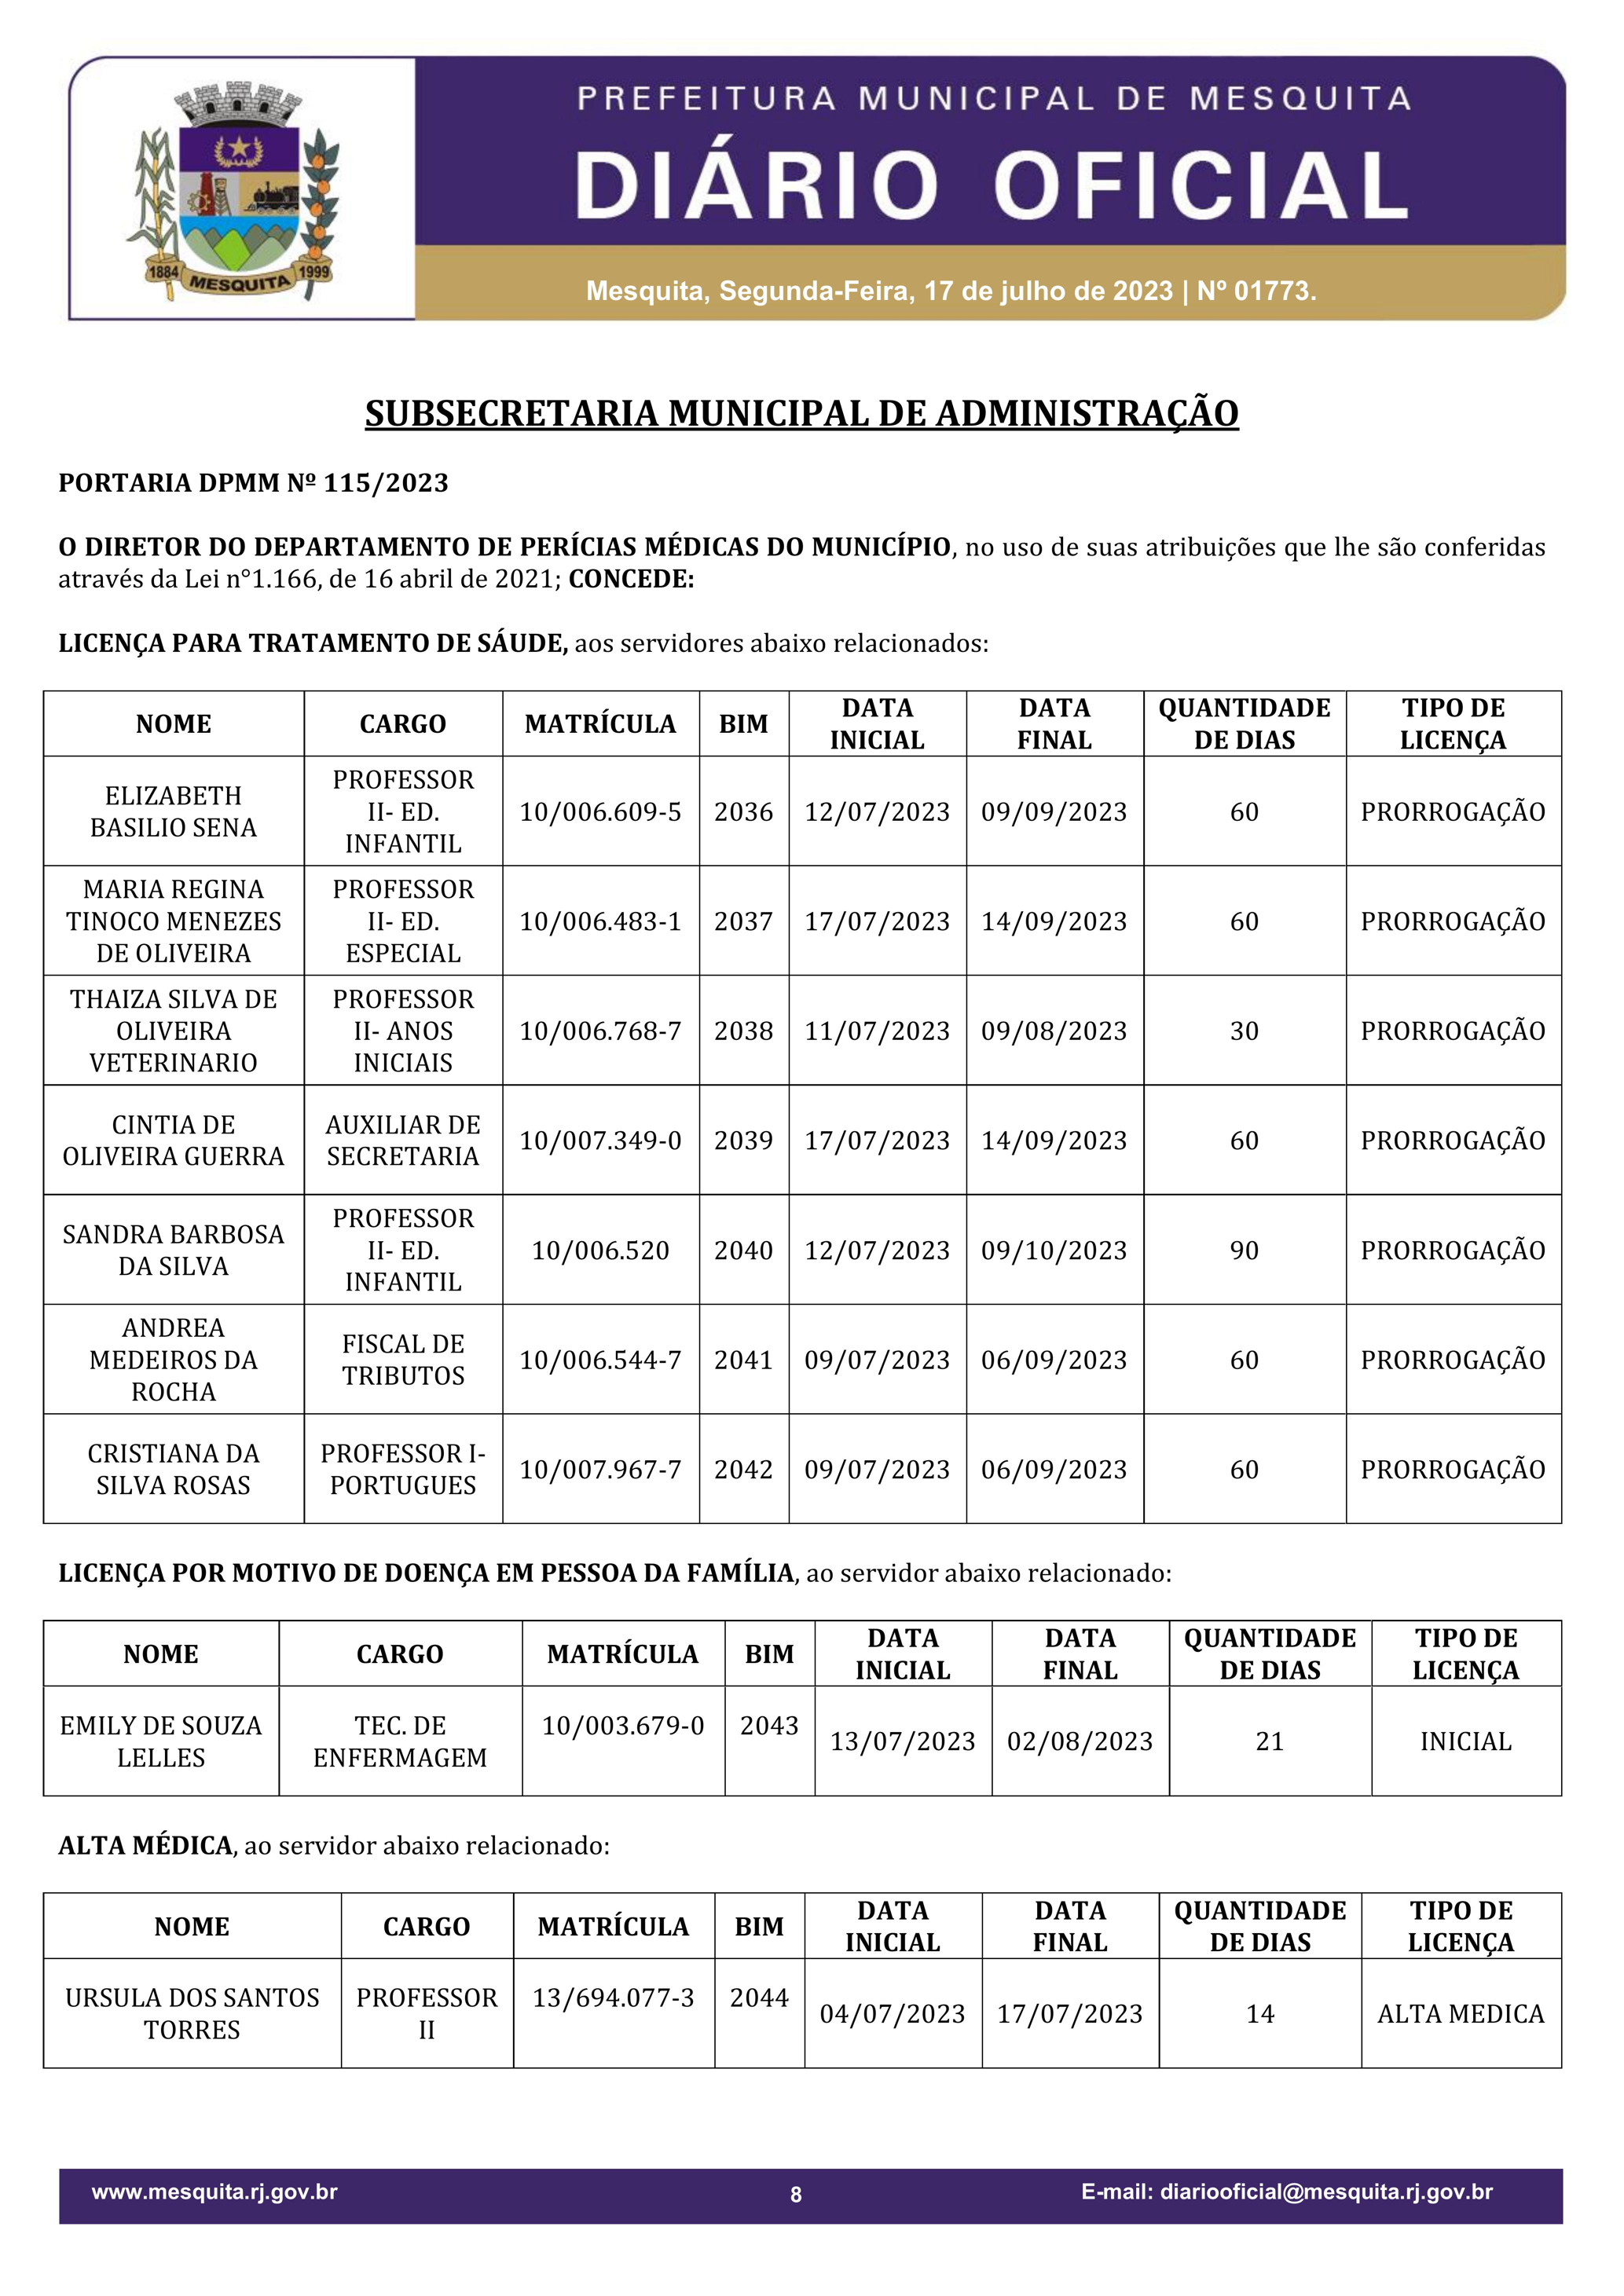

In [59]:
file_path = Image_file
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

In [60]:
from transformers import DetrImageProcessor

feature_extractor = DetrImageProcessor()
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

In [61]:
print(encoding['pixel_values'].shape)

torch.Size([1, 3, 1131, 800])


In [62]:
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

In [63]:
import torch

with torch.no_grad():
  outputs = model(**encoding)

In [64]:
import matplotlib.pyplot as plt

In [66]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [67]:
# rescale bounding boxes
width, height = image.size
results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]

In [68]:
results['scores']

tensor([0.8158, 0.9976, 0.9913])

In [69]:
results['labels']

tensor([0, 0, 0])

In [70]:
results['boxes']

tensor([[ 156.2763, 4027.4426, 3900.6052, 4452.9834],
        [ 166.3806, 4816.1318, 3921.6687, 5212.8604],
        [ 158.8127, 1755.1101, 3939.4470, 3811.2661]])

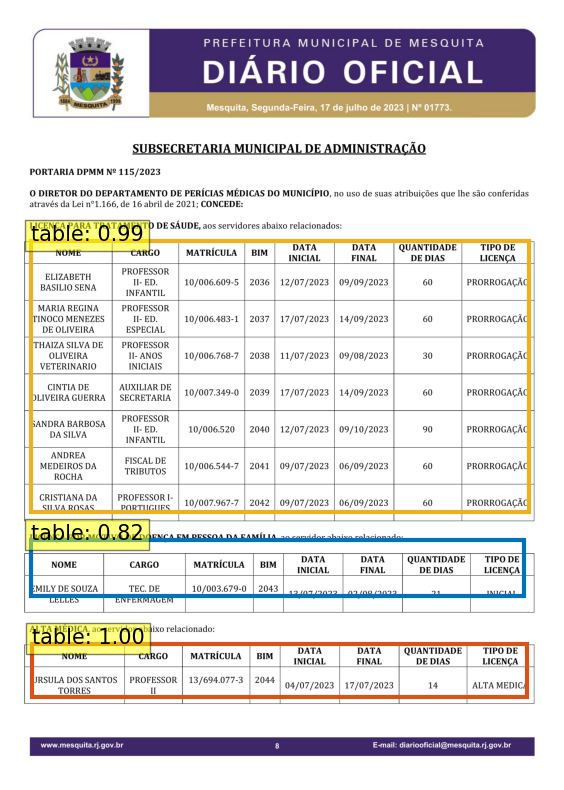

In [71]:
plot_results(image, results['scores'], results['labels'], results['boxes'])

## Table structure recognition



In [39]:
file_path = "PDF_samples/table_box/box1.png"

In [ ]:
file_path = "PDF_samples/table_box/box2.png"

In [ ]:
file_path = "PDF_samples/table_box/box3.png"

In [ ]:
file_path = "PDF_samples/table_box/box4.png"

In [ ]:
file_path = "PDF_samples/table_box/box5.png"

In [ ]:
file_path = "PDF_samples/table_box/box6.png"

In [72]:
file_path = "PDF_samples/table_box/box7.png"

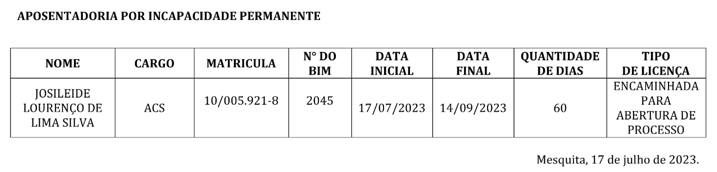

In [73]:
from huggingface_hub import hf_hub_download
from PIL import Image


image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

Let's prepare the image for the model using `DetrFeatureExtractor`.

In [74]:
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

In [75]:
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

In [76]:
with torch.no_grad():
  outputs = model(**encoding)

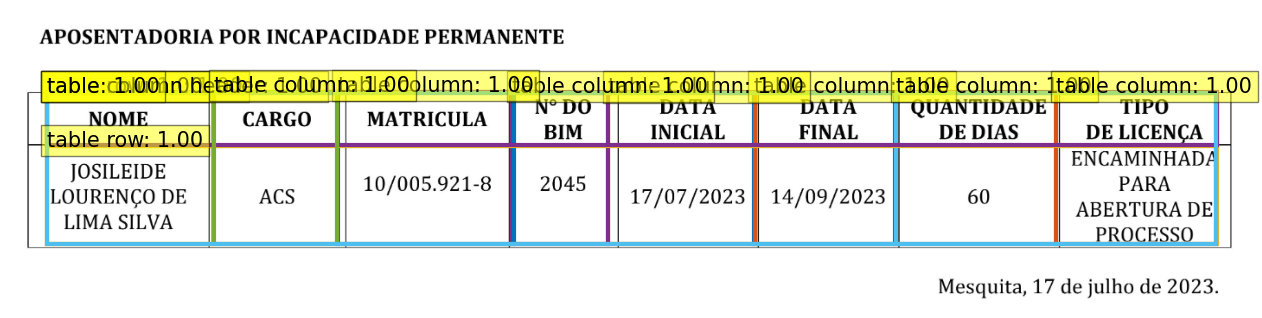

In [77]:
target_sizes = [image.size[::-1]]
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [78]:
model.config.id2label

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}

### Using Thinker

In [ ]:

from pdf2image import convert_from_path
from tkinter import *
from tkinter import messagebox
 
 
def pdf2img():
    try:
        images = convert_from_path(str(e1.get()))
        for img in images:
            img.save('new_folder\output.jpg', 'JPEG')
 
    except  :
        Result = "NO pdf found"
        messagebox.showinfo("Result", Result)
 
    else:
        Result = "success"
        messagebox.showinfo("Result", Result)
 
 
 
master = Tk()
Label(master, text="File Location").grid(row=0, sticky=W)
 
e1 = Entry(master)
e1.grid(row=0, column=1)
 
b = Button(master, text="Convert", command=pdf2img)
b.grid(row=0, column=2,columnspan=2, rowspan=2,padx=5, pady=5)
  
mainloop()